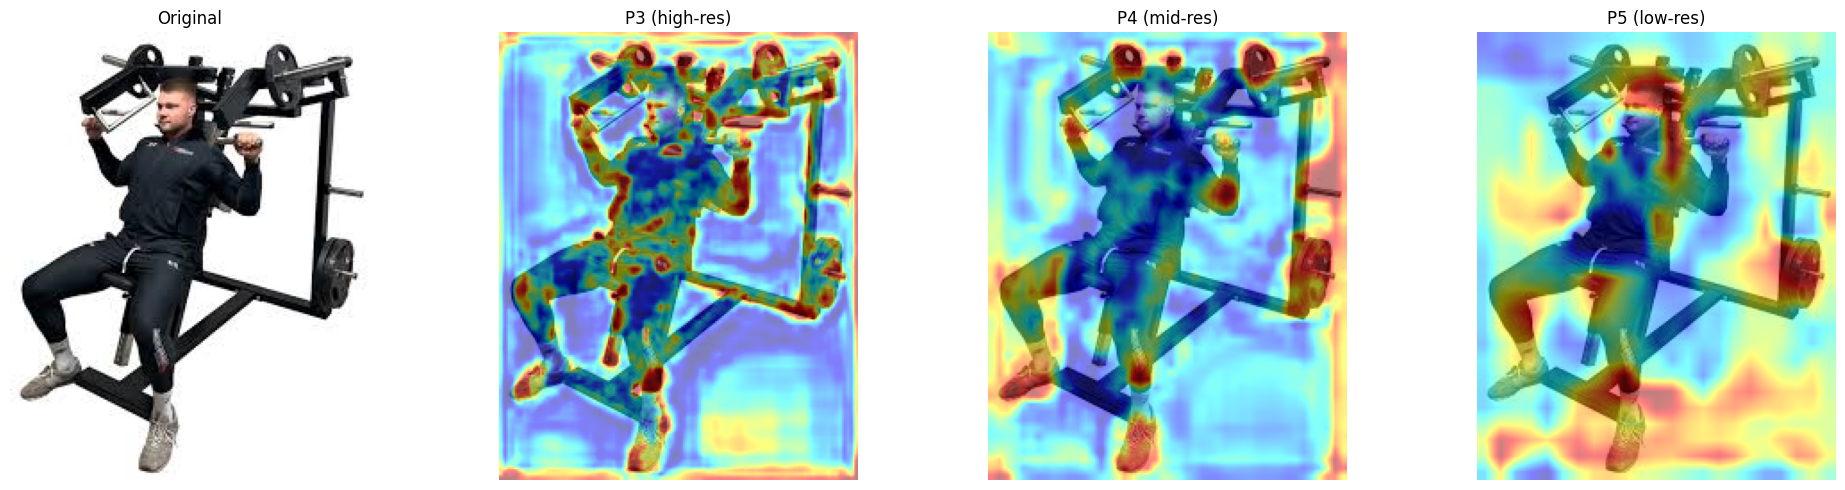

In [1]:
# --- 1) imports & settings ---
import cv2, torch, numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

IMGSZ = 896
PERC  = (2, 98)   # percentile scaling for contrast

# --- 2) helpers ---
def _find_detect(net):
    for m in net.modules():
        if m.__class__.__name__.lower() == "detect":
            return m
    raise RuntimeError("Detect head not found")

def _fmap_to_heat(feat, perc=PERC):
    # feat: [C,H,W] tensor (on CPU). Use L2 energy across channels for sharper maps.
    feat = feat.float().cpu()
    heat = torch.sqrt((feat**2).mean(dim=0) + 1e-9).numpy()
    lo, hi = np.percentile(heat, perc)
    heat = np.clip((heat - lo) / (hi - lo + 1e-6), 0, 1)
    return heat

def _overlay(bgr, heat, alpha=0.5):
    H, W = bgr.shape[:2]
    hm = cv2.applyColorMap((cv2.resize((heat*255).astype(np.uint8), (W, H))), cv2.COLORMAP_JET)
    out = (alpha*hm + (1-alpha)*bgr).astype(np.uint8)
    return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)  # for plt.imshow()

def get_pyramid(yolo, bgr, imgsz=IMGSZ):
    """Returns list of tensors [P3, P4, P5], each as [C,H,W] on CPU."""
    net = yolo.model
    detect = _find_detect(net)
    buf = {}

    def hook(m, inp, out):
        x = inp[0] if isinstance(inp, (list, tuple)) else inp
        xs = x if isinstance(x, (list, tuple)) else [x]   # [P3, P4, P5]
        buf["pyr"] = [xi.detach()[0].cpu() for xi in xs]  # take batch idx 0

    h = detect.register_forward_hook(hook)
    yolo.predict([bgr], imgsz=imgsz, conf=0.01, iou=0.5, save=False, workers=0, verbose=False)
    h.remove()
    if "pyr" not in buf:
        raise RuntimeError("Could not capture Detect inputs.")
    return buf["pyr"]

# --- 3) run on one image and SHOW inline ---
WEIGHTS = r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3best\weights\best.pt"
INPUT   =  r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\test_images\test_ohp_5.jpg"

y = YOLO(WEIGHTS)
bgr = cv2.imread(INPUT); assert bgr is not None, "Image not found"

pyr = get_pyramid(y, bgr)  # list of [C,H,W] tensors
names = ["P3 (high-res)", "P4 (mid-res)", "P5 (low-res)"][:len(pyr)]

# show original + overlays
fig, axes = plt.subplots(1, len(pyr)+1, figsize=(5*(len(pyr)+1), 5))
axes[0].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); axes[0].set_title("Original"); axes[0].axis("off")

for ax, name, feat in zip(axes[1:], names, pyr):
    heat = _fmap_to_heat(feat)
    vis  = _overlay(bgr, heat, alpha=0.5)
    ax.imshow(vis); ax.set_title(name); ax.axis("off")

plt.tight_layout(); plt.show()


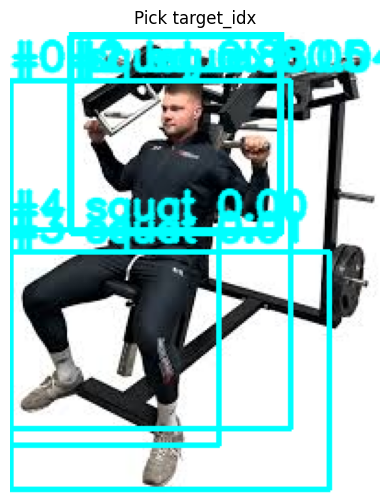

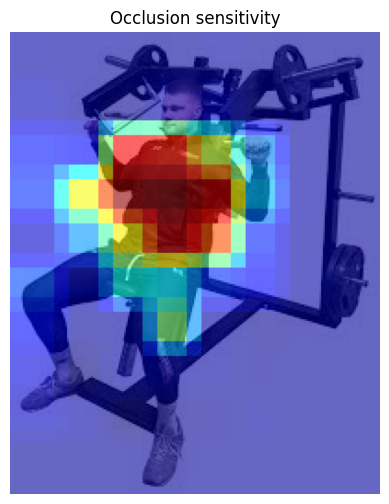

In [2]:
from captum.attr import Occlusion
import torchvision.transforms as T
import torch, numpy as np

# --- helpers ---
def overlay_heat(rgb, heat, alpha=0.6):
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    hm = cv2.applyColorMap((heat*255).astype(np.uint8), cv2.COLORMAP_JET)[:, :, ::-1]
    return (alpha*hm + (1-alpha)*rgb).astype(np.uint8)

def choose_target(model, rgb, conf=0.001, iou=0.5, max_det=50):
    """Run YOLO once, show boxes with indices, return (boxes, clses, confs)."""
    r = model.predict(rgb, conf=conf, iou=iou, verbose=False, save=False, max_det=max_det)[0]
    if len(r.boxes)==0:
        raise ValueError("No detections.")
    boxes = r.boxes.xyxy.cpu().numpy()
    clses = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()
    vis = rgb.copy()
    for i,(b,k,c) in enumerate(zip(boxes, clses, confs)):
        x1,y1,x2,y2 = b.astype(int)
        cv2.rectangle(vis,(x1,y1),(x2,y2),(0,255,255),2)
        cv2.putText(vis, f"#{i} {model.names[k]} {c:.2f}", (x1, max(20,y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2, cv2.LINE_AA)
    plt.figure(figsize=(8,6)); plt.imshow(vis); plt.axis("off"); plt.title("Pick target_idx")
    plt.show()
    return boxes, clses, confs

# --- model & image ---
yolo = YOLO(WEIGHTS)
rgb  = cv2.cvtColor(cv2.imread(INPUT), cv2.COLOR_BGR2RGB)
boxes, clses, confs = choose_target(yolo, rgb)
target_idx = 0  # <-- set after viewing the plot
tbox, tcls = boxes[target_idx], clses[target_idx]

class YoloTarget(torch.nn.Module):
    def __init__(self, model, tbox, tcls, iou_match=0.3):
        super().__init__()
        self.model, self.tbox, self.tcls = model, tbox, tcls
        self.iou_match = iou_match

    @torch.no_grad()
    def forward(self, x):  # BCHW in [0,1]
        out = []
        for i in range(x.shape[0]):
            img = (x[i].permute(1,2,0).cpu().numpy()*255).astype('uint8')
            r = self.model.predict(img, conf=0.001, iou=0.5, verbose=False, save=False)[0]
            if len(r.boxes)==0: out.append(0.0); continue
            bxs = r.boxes.xyxy.cpu().numpy()
            scs = r.boxes.conf.cpu().numpy()
            cls = r.boxes.cls.cpu().numpy().astype(int)

            m = (cls==self.tcls); bxs, scs = bxs[m], scs[m]
            if len(scs)==0: out.append(0.0); continue

            x1 = np.maximum(bxs[:,0], self.tbox[0]); y1 = np.maximum(bxs[:,1], self.tbox[1])
            x2 = np.minimum(bxs[:,2], self.tbox[2]); y2 = np.minimum(bxs[:,3], self.tbox[3])
            inter = np.maximum(0,x2-x1)*np.maximum(0,y2-y1)
            a1 = (self.tbox[2]-self.tbox[0])*(self.tbox[3]-self.tbox[1])
            a2 = (bxs[:,2]-bxs[:,0])*(bxs[:,3]-bxs[:,1])
            iou = inter/(a1+a2-inter+1e-6)

            j = iou.argmax()
            out.append(float(scs[j]) if iou[j] >= self.iou_match else 0.0)
        return torch.tensor(out, dtype=torch.float32).unsqueeze(1)

x = T.ToTensor()(rgb).unsqueeze(0)               # 1x3xHxW
baseline_rgb = np.mean(rgb.reshape(-1,3), axis=0)  # per-channel mean
baseline = torch.tensor(baseline_rgb/255.0, dtype=torch.float32).view(1,3,1,1)

wrapped = YoloTarget(yolo, tbox, tcls, iou_match=0.35)
occl = Occlusion(wrapped)
attr = occl.attribute(
    x, strides=(1,24,24), sliding_window_shapes=(3,32,32), baselines=baseline,
    perturbations_per_eval=16
).squeeze(0).mean(0).cpu().numpy()

plt.figure(figsize=(8,6))
plt.imshow(overlay_heat(rgb, attr))
plt.axis("off")
plt.title("Occlusion sensitivity")
plt.show()

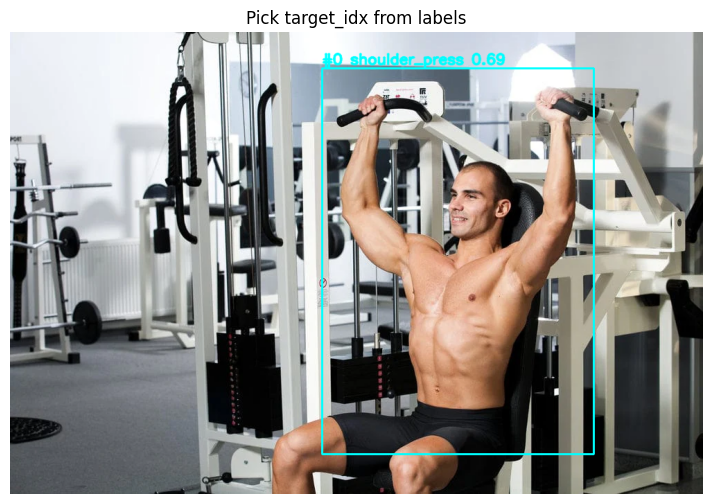

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
CONF_EVAL = 0.001   # keep low during explanation so masked objects still get found
IOU_EVAL  = 0.5

model = YOLO(WEIGHTS)
# INPUT   =  r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\test_images\photo_6_2025-11-12_09-48-49.jpg"
# INPUT   =  r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\test_images\test1.png"

# ---------------------
# Utilities
# ---------------------
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1,bx1), max(ay1,by1)
    inter_x2, inter_y2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, inter_x2 - inter_x1), max(0, inter_y2 - inter_y1)
    inter = iw * ih
    area_a = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    area_b = max(0, bx2 - bx1) * max(0, by2 - by1)
    union = area_a + area_b - inter + 1e-9
    return inter / union

def list_detections(img_path, conf=0.25, iou=0.5):
    res = model.predict(str(img_path), conf=conf, iou=iou, verbose=False, workers=0)[0]
    names = model.model.names

    boxes = res.boxes.xyxy.cpu().numpy()
    confs = res.boxes.conf.cpu().numpy()
    clses = res.boxes.cls.cpu().numpy().astype(int)

    # Read + convert to RGB with a contiguous buffer
    bgr = cv2.imread(str(img_path))
    if bgr is None:
        raise FileNotFoundError(f"Can't read image: {img_path}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)  # contiguous

    for i, (b, k, c) in enumerate(zip(boxes, clses, confs)):
        x1, y1, x2, y2 = b.astype(int)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(img, f"#{i} {names[k]} {c:.2f}", (x1, max(20, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)

    plt.figure(figsize=(9,6)); plt.imshow(img); plt.axis("off"); plt.title("Pick target_idx from labels")
    plt.show()
    return boxes, confs, clses


def score_for_target(img_bgr, tgt_cls, tgt_box, conf=CONF_EVAL, iou=IOU_EVAL):
    # run model, find same-class detection with max IoU; return its confidence (else 0)
    r = model.predict(img_bgr, conf=conf, iou=iou, verbose=False, workers=0)[0]
    if len(r.boxes) == 0: return 0.0
    boxes = r.boxes.xyxy.cpu().numpy()
    confs = r.boxes.conf.cpu().numpy()
    clses = r.boxes.cls.cpu().numpy().astype(int)
    same = np.where(clses == tgt_cls)[0]
    if same.size == 0: return 0.0
    ious = np.array([iou_xyxy(tgt_box, boxes[j]) for j in same])
    j = same[ious.argmax()]
    best_iou = ious.max()
    return float(confs[j]) if best_iou > 0 else 0.0

def overlay_heat(rgb, heat):
    # heat expected in [0,1], same HxW
    heat = np.clip(heat, 0, 1)
    cmap = plt.get_cmap("jet")(heat)[..., :3]  # RGB colormap
    out = (0.35*rgb + 0.65*cmap)  # blend
    return np.clip(out, 0, 1)

# ---------------------
# 1) Inspect detections & choose target_idx
# ---------------------
boxes, confs, clses = list_detections(INPUT, conf=0.25, iou=0.5)
# >>> Look at the figure and choose the index you want:
target_idx = 1  # <-- change this to the number printed on the box you want to explain

tgt_box = boxes[target_idx].tolist()
tgt_cls = int(clses[target_idx])

# Load image
orig_bgr = cv2.imread(INPUT)
H, W = orig_bgr.shape[:2]
orig_rgb = orig_bgr[:,:,::-1] / 255.0

# ---------------------
# 2) Occlusion sensitivity (sliding patch)
# ---------------------
def occlusion_map(img_bgr, patch=48, stride=24):
    baseline = score_for_target(img_bgr, tgt_cls, tgt_box)          # unmasked score
    heat = np.zeros((H, W), np.float32)
    counts = np.zeros((H, W), np.float32)
    mean_color = img_bgr.mean(axis=(0,1), keepdims=True)            # fill color

    for y in range(0, H, stride):
        for x in range(0, W, stride):
            x2, y2 = min(x+patch, W), min(y+patch, H)
            masked = img_bgr.copy()
            masked[y:y2, x:x2, :] = mean_color
            s = score_for_target(masked, tgt_cls, tgt_box)
            drop = max(0.0, baseline - s)                           # score drop
            heat[y:y2, x:x2] += drop
            counts[y:y2, x:x2] += 1.0

    heat /= counts + 1e-6
    if heat.max() > 0: heat /= heat.max()
    return heat

occ = occlusion_map(orig_bgr, patch=48, stride=24)

# ---------------------
# 3) RISE saliency (random masks)
# ---------------------
def rise_map(img_bgr, N=600, s=7, p=0.5):
    """
    N: number of random masks
    s: small mask resolution (s x s), will be upsampled to HxW
    p: keep probability for each cell
    """
    base = score_for_target(img_bgr, tgt_cls, tgt_box)
    acc = np.zeros((H, W), np.float32)
    for _ in range(N):
        m_small = (np.random.rand(s, s) < p).astype(np.float32)
        m = cv2.resize(m_small, (W, H), interpolation=cv2.INTER_NEAREST)[..., None]
        masked = (img_bgr * m).astype(np.uint8)
        s_mask = score_for_target(masked, tgt_cls, tgt_box)
        # weight by score (optionally normalize by base)
        acc += (s_mask / max(base, 1e-6)) * m.squeeze(-1)

    acc = acc / N
    if acc.max() > 0: acc /= acc.max()
    return acc

rise = rise_map(orig_bgr, N=600, s=7, p=0.5)

# ---------------------
# 4) Visualize side-by-side
# ---------------------
plt.figure(figsize=(14,5))
plt.subplot(1,3,1); plt.imshow(orig_rgb); plt.axis("off"); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(overlay_heat(orig_rgb, occ)); plt.axis("off"); plt.title("Occlusion sensitivity")
plt.subplot(1,3,3); plt.imshow(overlay_heat(orig_rgb, rise)); plt.axis("off"); plt.title("RISE saliency")
plt.show()